# Scikit-Learn
> 使用sklearn 训练模型

# 介绍
有监督的机器学习算法涉及5个主要步骤:

1. 特征选择和标注训练样本的收集
2. 选择Performance Metrics
3. 选择学习算法并训练模型
4. 对模型性能进行评估
5. 更改算法的设置并调整模型

# 训练一个感知器模型
使用scikit-learn自带的iris数据集训练一个感知器模型

安装 sklearn
```
conda install scikit-learn
```

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target

In [22]:
np.unique(y)

array([0, 1, 2])

`np.unique(y)`方法返回3个唯一的label, 也就是Iris 的三个类别: Iris-setosa, Iris-versicolor, Iris-virginica

使用`model_selection`的`train_test_split`方法分隔测试集和验证集

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

::: {.callout-note}
在分隔前，`train_test_split`函数内部已经对数据进行了shuffle。 
:::

通过`stratify=y`配置，可以保证训练集和测试集有相同比例的label，可以通过Numpy的`np.bincount`函数进行验证

In [33]:
np.bincount(y), np.bincount(y_train), np.bincount(y_test)

(array([50, 50, 50]), array([35, 35, 35]), array([15, 15, 15]))

许多机器学习和优化算法要求对特征进行归一化，以获得最佳性能, scikit-learn使用`preprocessing`的`StandardScaler`类来完成这个操作

In [34]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

训练数据标准化后，我们就可以开始训练感知器模型。Scikit-learn的大多数算法都通过**one-versus-rest(OvR)**支持多分类, 这种方法允许我们将三个花类输入给模型

In [35]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

训练完模型后，使用`predict`方法进行预测

In [36]:
y_pred = ppn.predict(X_test_std)
print('MIsclassified examples: %d' % (y_test != y_pred).sum())

MIsclassified examples: 1


可以看出模型的错误率只有1/45,约等于0.022. scikit-learn也有自己的精度计算函数`accuracy_score`

In [37]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')

Accuracy: 0.978


展示决策模型, 参见图: @fig-iris-rigion

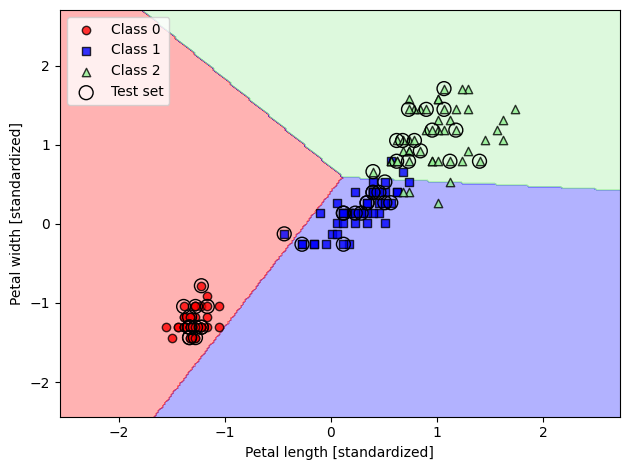

In [38]:
#| label: fig-iris-rigion
#| fig-cap: Decision boundaries of a multi-cllass perceptron model fitted to the Iris dataset
#| fig-alt: Iris Rigion

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')
        
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 基于逻辑回归的模型

当我们的数据不能进行完美的线性分隔时，感知器模型就不能很好的工作了。 因此我们需要逻辑回归模型

## Logistic regression and conditional probabillities
逻辑回归是一个非常容易实现的分类模型，并且在线性分隔时执行得很好。 它是工业界最广泛使用的分类模型之一。

首先，先来看看激活函数Sigmoid的图形，参见： @fig-sigmoid

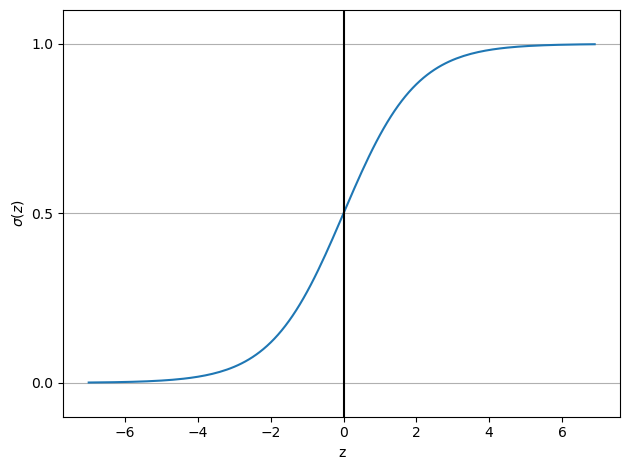

In [25]:
#| label: fig-sigmoid
#| fig-cap: A plot of the logistic sigmoid function

import matplotlib.pylab as plt
import numpy as np
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

## 模型训练

scikit-learn 有两类回归模型，LogisticRegression和LinearRegression。 它们在功能和适用场景上有所不同。
逻辑回归只适用于二分类模型，所以只能使用0,1类别的数据

1. LinearRegression（线性回归）: 用于建立线性回归模型，用于预测一个或多个连续数值型目标变量。
2. LogisticRegression（逻辑回归）：用于建立逻辑回归模型，用于预测二分类或多分类问题。它使用逻辑函数（如sigmoid函数）将线性回归的输出映射到概率值，并根据阈值进行分类

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs',multi_class='ovr')
lr.fit(X_train_std, y_train)

LogisticRegression(C=100.0, multi_class='ovr')

看一下预测结果，参见: @fig-logistic

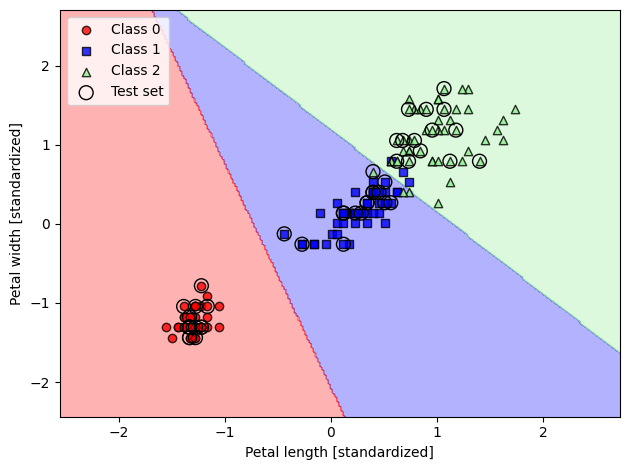

In [13]:
#| label: fig-logistic
#| fig-cap: Decision rigions for scikit-learn's multi-class logistic regression model

plot_decision_regions(X_combined_std,
                       y_combined,
                       classifier=lr,
                       test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

如果想看每个分类的预测概率，可以使用`predict_proba`

In [14]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

上面每一行的3个数代表每个分类的概率，所有的概率想加为1

In [33]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

使用`argmax`函数来获取最大概率的列索引

In [34]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

上面的代码和直接调用predict相同

In [35]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

# 模型优化技巧

## 交叉验证(Cross-Validation)
[参见：官网文档](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

使用不同的数据作为验证集，当满足如下情况时，可以考虑使用这个方法
![data](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)
* 对于小数据量的情况，额外的训练工作消耗资源不多



In [39]:
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90, 4), (90,), (60, 4), (60,))

In [43]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

## Computing cross-validated metrics

In [44]:
from sklearn.model_selection import cross_val_score

clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

The mean score and the standard deviation are hence given by:

In [45]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02
